In [55]:
import pandas as pd
import seaborn as sns

# load dataframe
df = pd.read_csv("../data/bank-full.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [56]:
import numpy as np
from scipy import stats

df = df[(np.abs(stats.zscore(df['balance'])) < 3)]

# set y to binary
df['y'] = np.where(df['y'] == 'yes', 1, 0)

# drop time (for simplicity)
# drop until we get more domain information on this variable
# drop columns that are not controlled by marketers
df.drop(columns=["day", "month", "duration"], inplace=True)

# one hot encoding
df['job'] = df['job'].astype('category')
df['marital'] = df['marital'].astype('category')
df['education'] = df['education'].astype('category')
df['default'] = df['default'].astype('category')
df['housing'] = df['housing'].astype('category')
df['loan'] = df['loan'].astype('category')
df['contact'] = df['contact'].astype('category')
df['poutcome'] = df['poutcome'].astype('category')

df = pd.get_dummies(df)

df = df.apply(lambda x: x.astype(float))

df.to_csv("../data/bank-cleaned.csv", index=False)

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn import tree

# make test train split
X = df.loc[:, df.columns != 'y']
y = df["y"]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.20, random_state=42)

In [59]:
# Logistic Regression
log = LogisticRegression(random_state=0, max_iter = 10_000)
log.fit(X_train, y_train)

for i in range(len(X.columns)):
  print(X.columns[i], log.coef_[0][i])

age 0.0015059250826208275
balance 6.743011336408907e-05
campaign -0.10898919575021597
pdays -4.41122035373197e-05
previous 0.0013654370300377166
job_admin. -0.015941259638051295
job_blue-collar -0.22875636211663583
job_entrepreneur -0.14836335760856917
job_housemaid -0.14804967611759035
job_management -0.1288048009772123
job_retired 0.42255187626971635
job_self-employed -0.10895371436975995
job_services -0.14983759318029188
job_student 0.23495686769734742
job_technician -0.17611512897730064
job_unemployed 0.06092708379733373
job_unknown -0.03220840064384753
marital_divorced -0.13587977805435475
marital_married -0.3096449465851286
marital_single 0.02693025877763677
education_primary -0.2835193074857143
education_secondary -0.14783743105719055
education_tertiary 0.048175487383673735
education_unknown -0.03541321473349227
default_no -0.2645255547017255
default_yes -0.1540689111574148
housing_no 0.06654999785961326
housing_yes -0.4851444637832362
loan_no 0.045003564531211196
loan_yes -0.46

In [93]:
predictions = log.predict(X_test)

# generate confusion matrix
confusion_matrix(y_test, predictions)

array([[7821,   89],
       [ 828,  156]], dtype=int64)

In [94]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

(tn, fp, fn, tp)

(7821, 89, 828, 156)

In [89]:
# calculate accuracy
log.score(X_test, y_test)

0.8968967843489993

In [90]:
from sklearn.metrics import recall_score, precision_score

recall_score(y_test, predictions)

0.15853658536585366

In [95]:
precision_score(y_test, predictions)

0.636734693877551

In [64]:
## Alternative logistic regression
import statsmodels.api as sm

model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = model.fit()
results.params

age                    0.002564
balance                0.000068
campaign              -0.107568
pdays                  0.000285
previous               0.006986
job_admin.            -0.005415
job_blue-collar       -0.198409
job_entrepreneur      -0.298235
job_housemaid         -0.321021
job_management        -0.156303
job_retired            0.460569
job_self-employed     -0.206912
job_services          -0.133872
job_student            0.470247
job_technician        -0.159040
job_unemployed         0.101768
job_unknown           -0.237516
marital_divorced      -0.185420
marital_married       -0.433519
marital_single        -0.065201
education_primary     -0.346330
education_secondary   -0.193514
education_tertiary     0.003819
education_unknown     -0.148114
default_no            -0.226199
default_yes           -0.457940
housing_no            -0.065463
housing_yes           -0.618676
loan_no               -0.118043
loan_yes              -0.566096
contact_cellular       0.167681
contact_

In [65]:
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                35572
Model:                            GLM   Df Residuals:                    35542
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11068.
Date:                Mon, 08 May 2023   Deviance:                       22137.
Time:                        13:34:23   Pearson chi2:                 3.71e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.09698
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                     0.0026    

In [96]:
# DECISION TREE
treeclf = tree.DecisionTreeClassifier(max_depth=2)
treeresults = treeclf.fit(X_train, y_train)

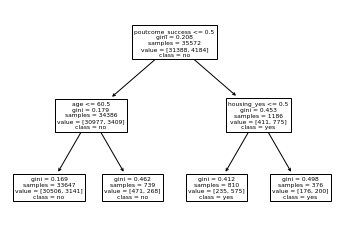

In [97]:
import matplotlib.pyplot as plt

tree.plot_tree(treeclf, feature_names=X.columns, class_names=["no", "yes"])
plt.savefig('tree.pdf',format='pdf',bbox_inches = "tight")

In [98]:
y_pred = treeclf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[7799,  111],
       [ 811,  173]], dtype=int64)

In [101]:
treeclf.score(X_test, y_test)

0.8963346076006297

In [99]:
recall_score(y_test, y_pred)

0.1758130081300813

In [100]:
precision_score(y_test, y_pred)

0.6091549295774648

In [74]:
from sklearn.ensemble import RandomForestClassifier

# ENSEMBLE METHODS: RANDOM FORESTS
randomclf = RandomForestClassifier(max_depth=5, random_state=0)
randomclfresults = randomclf.fit(X_train, y_train)

In [75]:
y_pred = randomclf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[7842,   68],
       [ 857,  127]], dtype=int64)